In [50]:
import os
import numpy as np
import pandas as pd
from scipy.stats import chisquare, kstest
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv(r'../doc/Walmart.csv', parse_dates=['Date'])
df.head(1)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-05-02,1643690.9,0,42.31,2.572,211.096358,8.106


In [3]:
TARGET = 'Weekly_Sales'
FEATURE_ALL = {'Store', 'Date', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment'}
FEATURE_CAT = {'Store', 'Date', 'Holiday_Flag'}
FEATURE_CONT = FEATURE_ALL - FEATURE_CAT

In [53]:
# vars_dist(df, catex, ft_catex, cont, ft_cont, output, fname, fpath, subplots, figsize)
def vars_dist(df=None, catex=False, ft_catex=None, cont=False, ft_cont=None, output=False, fname=None, fpath=None, subplots=None, figsize=None):
    ''' Generate single variable's statistics & distribution, and save

    Args:
        df: DataFrame, input data for analysis
        catex: True if analyze categorical features, otherwise False
        ft_catex: List, categorical features
        cont: True if analyze continuous features, otherwise False
        ft_cont: List, continuous features
        output: True if generate file and save, otherwise False
        fname: str, file name if need to output
        fpath: path to store files, starting with r''
        subplots: List, # of plots
        figsize: tuple, figure size

    Returns:
        DataFrame
    '''
    sns.set()
    fig, axes = plt.subplots(subplots[0], subplots[1], figsize=figsize)
    ax, i, cols = axes.flatten(), 0, list(ft_catex) if catex == True else list(ft_cont)
    if catex == True:
        res = pd.DataFrame(columns=['Variable', 'Type', 'Records', 'Unique', 'Mean', 'Std', 'Median', 'Pctile_25', 'Pctile_75', 'Chi-square', 'P-value', 'Conclusion'])
        for col in cols:
            temp = sns.countplot(data=df, x=col, ax=ax[i])
            temp.set(xlabel=col, ylabel=f"Count of {col}", title=f"Count Plot of {col}")
            if df.loc[:, col].nunique() > 10:
                temp.set(xticklabels=[])
            else:
                tol = len(getattr(df, col))
                for p in ax[i].patches:
                    txt = str((100*p.get_height()/tol).round(2)) + '%'
                    x, y = p.get_x(), p.get_height()
                    ax[i].annotate(txt, (x, y), fontsize=15)
            col_cnt = getattr(df, col).value_counts()
            chi_sq = chisquare(np.array(col_cnt), np.repeat(len(getattr(df, col))/len(col_cnt), len(col_cnt)))
            if chi_sq[1] < 0.05:
                conclus = 'Imbalanced'
            else:
                conclus = 'Evenly-Distributed'
            df_temp = pd.DataFrame({'Variable': [col], 'Type': ['Categorical'], 'Records': [len(getattr(df, col))], 
                                    'Unique': [getattr(df, col).nunique()], 'Mean': [round(col_cnt.mean(), 2)], 'Std': [round(col_cnt.std(), 2)], 
                                    'Median': [round(col_cnt.median(), 2)], 'Pctile_25': [round(col_cnt.quantile(q=0.25), 2)], 'Pctile_75': [round(col_cnt.quantile(q=0.75), 2)], 
                                    'Chi-square': [round(chi_sq[0], 2)], 'P-value': [round(chi_sq[1], 2)],
                                    'Conclusion': [conclus]})
            res = pd.concat([res, df_temp])
            i += 1
            col_cnt.mean(), col_cnt.std(), col_cnt.median(), col_cnt.quantile(q=0.25), col_cnt.quantile(q=0.75)
        plt.suptitle('Distribution of Categorical Variables')
    else:
        res = pd.DataFrame(columns=['Variable', 'Type', 'Records', 'Mean', 'Std', 
                                    'Median', 'Pctile_25', 'Pctile_75', 'IQR', 'R_Lo', 'R_Hi', 
                                    'Skewness', 'Kurtosis', 'KS_stat', 'KS_P_val'])
        for col in cols:
            temp = sns.histplot(getattr(df, col), kde=True, color='purple', ax=ax[i])
            temp.set(xlabel=col, ylabel='Density', title=f"Histogram of {col}")
            i += 1
            temp = sns.boxplot(getattr(df, col), width=0.3, palette=['m'], ax=ax[i])
            temp.set(xlabel=col, xticklabels=[], ylabel='Value', title=f"Boxplot of {col}")
            df_temp = pd.DataFrame({'Variable': [col], 'Type': ['Continuous'], 'Records': [len(getattr(df, col))], 
                                    'Mean': [round(getattr(df, col).mean(), 2)], 'Std': [round(getattr(df, col).std(), 2)], 'Median': [round(getattr(df, col).median(), 2)], 
                                    'Pctile_25': [round(getattr(df, col).quantile(q=0.25), 2)], 'Pctile_75': [round(getattr(df, col).quantile(q=0.75), 2)], 
                                    'IQR': [round(getattr(df, col).quantile(q=0.75)-getattr(df, col).quantile(q=0.25), 2)], 
                                    'R_Lo': [round(getattr(df, col).quantile(q=0.25)-1.5*(getattr(df, col).quantile(q=0.75)-getattr(df, col).quantile(q=0.25)), 2)], 
                                    'R_Hi': [round(getattr(df, col).quantile(q=0.75)+1.5*(getattr(df, col).quantile(q=0.75)-getattr(df, col).quantile(q=0.25)), 2)],
                                    'Skewness': [round(getattr(df, col).skew(), 2)], 'Kurtosis': [round(getattr(df, col).kurt(), 2)],
                                    'KS_stat': [round(kstest(getattr(df, col), 'norm')[0], 2)], 'KS_P_val': [round(kstest(getattr(df, col), 'norm')[1], 2)]})
            res = pd.concat([res, df_temp])
            i += 1
        plt.suptitle('Distribution of Continuous Variables')
        
    plt.tight_layout()
    
    if output == True:
        plt.savefig(os.path.join(fpath, fname))

    return res.reset_index().drop(columns=['index'])

,Variable,Type,Records,Mean,Std,Median,Pctile_25,Pctile_75,IQR,R_Lo,R_Hi,Skewness,Kurtosis,KS_stat,KS_P_val
0,Unemployment,Continuous,6435,8.00,1.88,7.87,6.89,8.62,1.73,4.29,11.22,1.19,2.64,1.00,0.0
1,CPI,Continuous,6435,171.58,39.36,182.62,131.74,212.74,81.01,10.22,334.26,0.06,-1.84,1.00,0.0
2,Weekly_Sales,Continuous,6435,1046964.88,564366.62,960746.04,553350.10,1420158.66,866808.56,-746862.73,2720371.49,0.67,0.05,1.00,0.0
3,Fuel_Price,Continuous,6435,3.36,0.46,3.44,2.93,3.74,0.80,1.73,4.94,-0.10,-1.18,0.99,0.0
4,Temperature,Continuous,6435,60.66,18.44,62.67,47.46,74.94,27.48,6.24,116.16,-0.34,-0.61,1.00,0.0


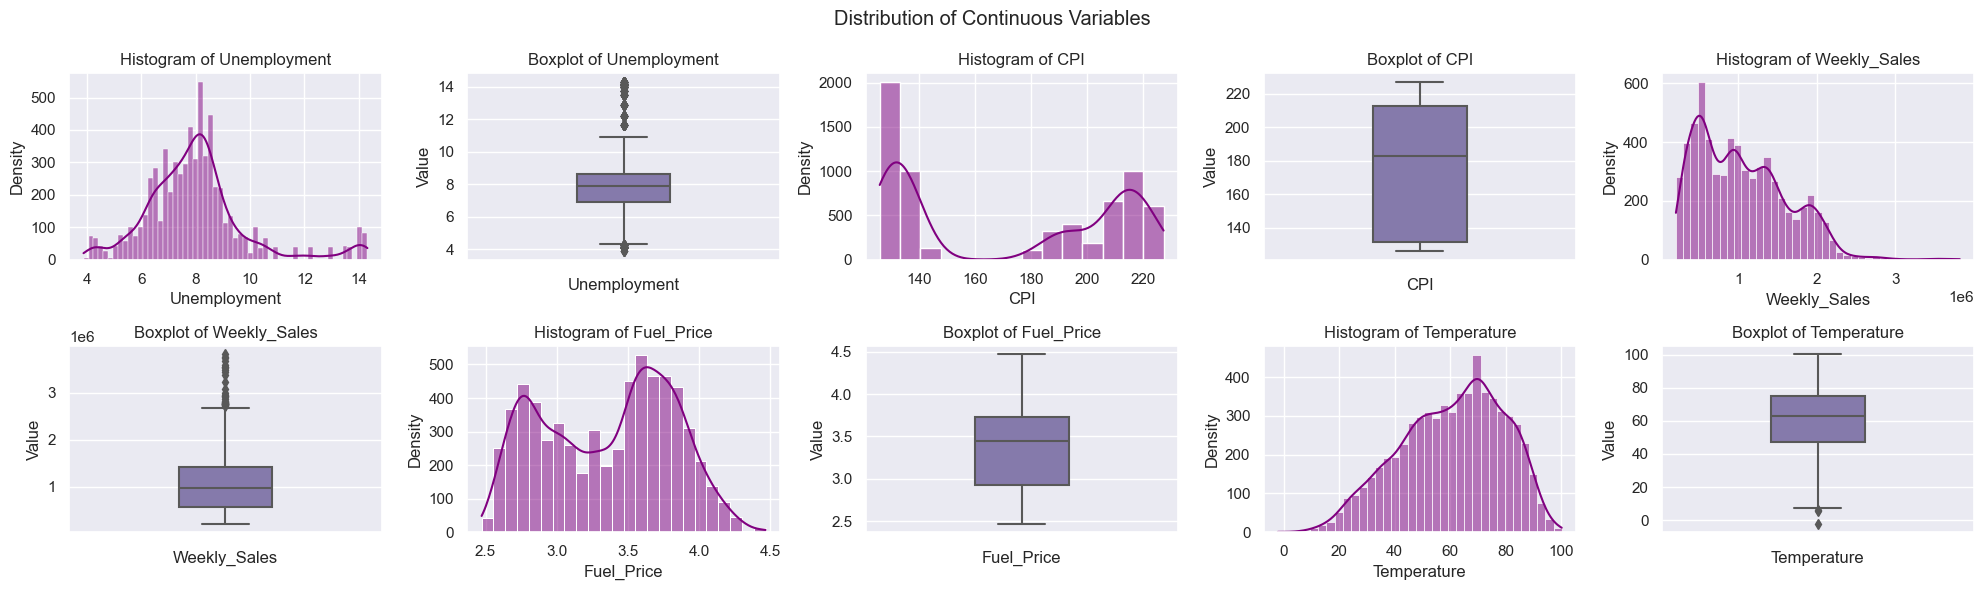

In [54]:
cont_vars = FEATURE_CONT.union({TARGET})
res = vars_dist(df=df, cont=True, ft_cont=cont_vars, subplots=[2,5], figsize=(20,6))
res

,Variable,Type,Records,Unique,Mean,Std,Median,Pctile_25,Pctile_75,Chi-square,P-value,Conclusion
0,Date,Categorical,6435,143,45.0,0.00,45.0,45.00,45.00,0.00,1.0,Evenly-Distributed
1,Store,Categorical,6435,45,143.0,0.00,143.0,143.00,143.00,0.00,1.0,Evenly-Distributed
2,Holiday_Flag,Categorical,6435,2,3217.5,3913.84,3217.5,1833.75,4601.25,4760.87,0.0,Imbalanced


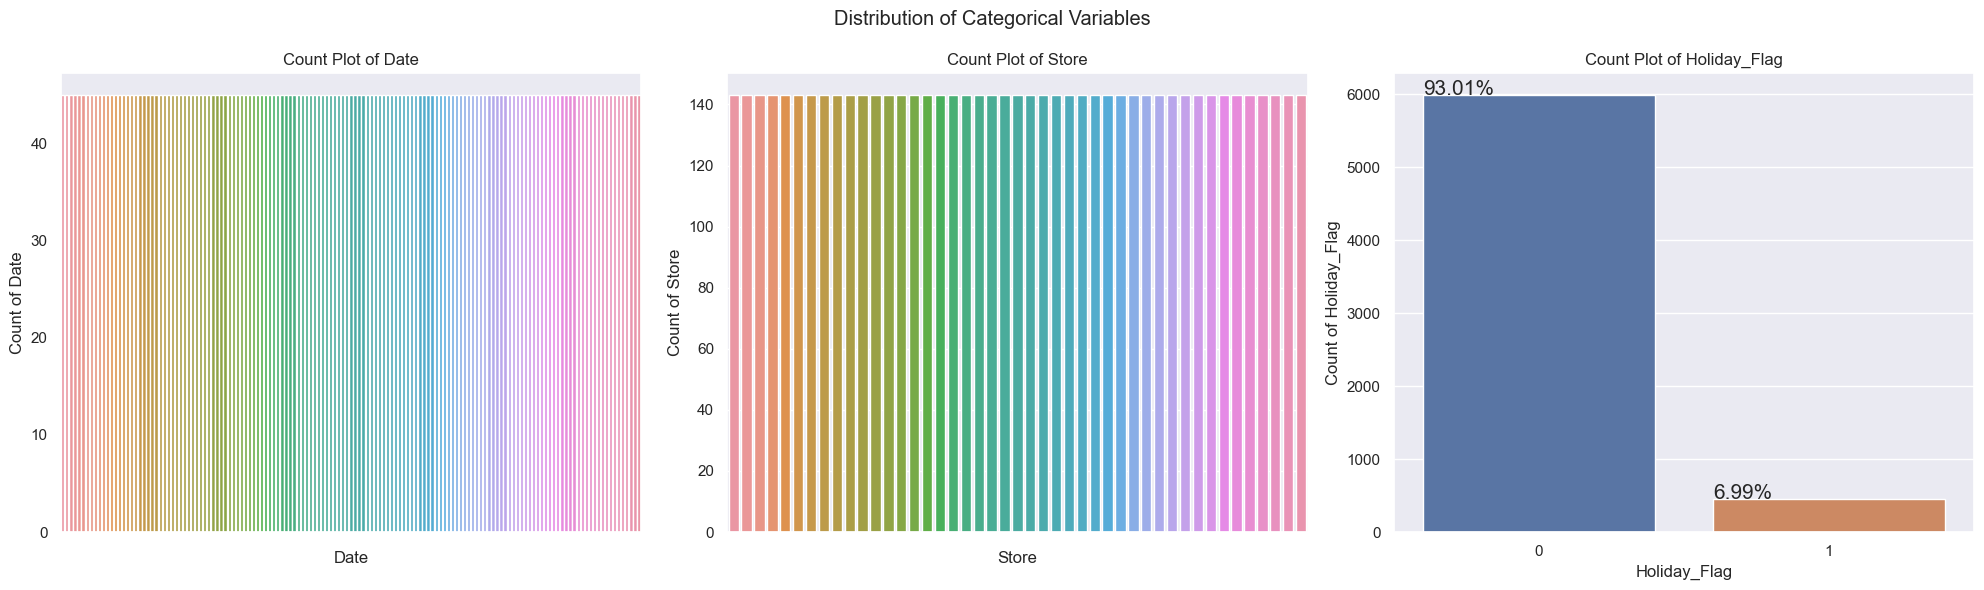

In [35]:
ress = vars_dist(df=df, catex=True, ft_catex=FEATURE_CAT, subplots=[1,3], figsize=(20,6))
ress